In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TIMESTEP = 0.001 # needs to evenly divide 0.04, should match input to t_toss when called
FRAMERATE = 25 # FPS in original video, should be 25
prev_hand_kp = [0, 0]

In [3]:
def readfile(n):
    if n < 10:
        numstring = "000" + str(n)
    elif n < 100:
        numstring = "00" + str(n)
    elif n < 1000:
        numstring = "0" + str(n)
    else:
        numstring = str(n)

    filename = "~/Desktop/Expressive-MP/waypoints/arbor/arbor3_00000000" + numstring + "_keypoints.json"

    item = pd.read_json(filename)
    return item

def extract_angles(shoulder, elbow, wrist, fingertip):
    """
    Given the positions of the shoulder, elbow, wrist, 
    and fingertip, extract the three desired angles.
    """
    xdiff1 = elbow[0] - shoulder[0]
    ydiff1 = elbow[1] - shoulder[1]
    theta1 = np.arctan2(ydiff1, xdiff1)
    
    xdiff2 = wrist[0] - elbow[0]
    ydiff2 = wrist[1] - elbow[1]
    theta2 = np.arctan2(ydiff2, xdiff2)
    
    xdiff3 = fingertip[0] - wrist[0]
    ydiff3 = fingertip[1] - wrist[1]
    theta3 = np.arctan2(ydiff3, xdiff3)

    return [theta1, theta2, theta3]

def get_hand_kpt(d):
    """
    Hand keypoint detection is extremely noisy, so we do 
    the best we can and allow for lots of smoothing later.
    """
    global prev_hand_kp
    
    keypoints = d['hand_right_keypoints_2d']
    for i in [12, 16, 8, 20]:
        p = keypoints[3 * i: 3 * i + 2]
        if p[0] != 0 and p[1] != 0:
            prev_hand_kp = p
            return p
    return prev_hand_kp

def linear_interp(array, num):
    interpolated = array[0]
    for i in range(len(array) - 1):
        interp = np.linspace(array[i], array[i + 1], num)
        interpolated = np.vstack([interpolated, interp])
        
    return interpolated

def fourier_filter(array, thresh):
    fourier = np.fft.rfft(array)
    fourier[np.abs(fourier) < thresh] = 0
    filtered = np.fft.irfft(fourier)
    return filtered

In [4]:
theta_list = []

for n in range(1345):
    d = readfile(n)["people"][0]
    series = d['pose_keypoints_2d']
    pt0 = series[0:2]
    pt1 = series[3:5]
    pt2 = series[6:8]
    pt3 = series[9:11]
    pt4 = series[12:14]
    hand_pt = get_hand_kpt(d)

    thetas = extract_angles(pt2, pt3, pt4, hand_pt)
    theta_list.append(thetas)

tl = np.array(theta_list)

In [5]:
tl[tl < 0] = tl[tl < 0] + 2 * np.pi
kernel = np.array([1, 2, 4, 6, 10, 14, 17, 19, 17, 14, 10, 6, 4, 2, 1])
#kernel = np.ones(9)
kernel = kernel / np.sum(kernel)

smoothed_thetas = np.vstack([np.convolve(tl[:, 0], kernel, mode='same'), 
                             np.convolve(tl[:, 1], kernel, mode='same'), 
                             np.convolve(tl[:, 2], kernel, mode='same')])

data = smoothed_thetas[:, 150:560] - np.pi / 2
t = np.arange(len(data[0])) / FRAMERATE

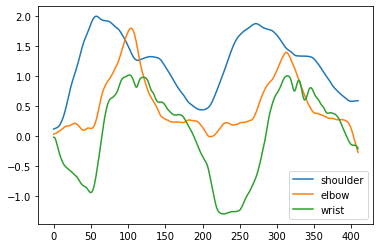

In [6]:
plt.plot(np.arange(len(data[0])), data[0], label="shoulder")
plt.plot(np.arange(len(data[0])), data[1] - data[0], label="elbow")
plt.plot(np.arange(len(data[0])), data[2] - data[1], label="wrist")
plt.legend()

In [7]:
# output = np.vstack([t, 
#                     np.zeros_like(t), 
#                     -data[0], 
#                     data[0] - data[1], 
#                     data[1] - data[2], 
#                     np.ones_like(t) * np.pi / 2,
#                     np.zeros_like(t)
#                    ]).T

# output = linear_interp(output, 20)
# output = np.hstack([output, np.zeros_like(output), np.zeros_like(output), np.zeros_like(output)])

# output = np.round_(output, decimals=5)
# np.savetxt("dance.dat", output, fmt="%10.5f", delimiter='\t')

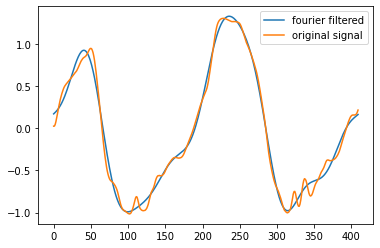

[[ 0.000000e+00  0.000000e+00 -4.020500e-01 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 0.000000e+00  0.000000e+00 -4.020500e-01 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 1.030000e-03  0.000000e+00 -4.022400e-01 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 ...
 [ 1.635795e+01  0.000000e+00 -3.956300e-01 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 1.635897e+01  0.000000e+00 -3.957500e-01 ...  0.000000e+00
   0.000000e+00  0.000000e+00]
 [ 1.636000e+01  0.000000e+00 -3.958700e-01 ...  0.000000e+00
   0.000000e+00  0.000000e+00]]


In [8]:
sh = 0 - data[0]
el = data[0] - data[1]
wr = data[1] - data[2]

sh_filtered = fourier_filter(sh, 25)
el_filtered = fourier_filter(el, 15)
wr_filtered = fourier_filter(wr, 10)

plt.plot(np.arange(len(data[0])), wr_filtered, label="fourier filtered")
plt.plot(np.arange(len(data[0])), wr, label="original signal")
plt.legend()
plt.show()


output = np.vstack([t, 
                    np.zeros_like(t), 
                    sh_filtered, 
                    el_filtered, 
                    wr_filtered, 
                    np.ones_like(t) * np.pi / 2,
                    np.zeros_like(t)
                   ]).T
output = linear_interp(output, int(1 / FRAMERATE / TIMESTEP))
output = np.hstack([output, np.zeros_like(output), np.zeros_like(output), np.zeros_like(output)])
output = np.round_(output, decimals=5)
print(output)
np.savetxt("dance.dat", output, fmt="%10.5f", delimiter='\t')